## Whisper 將 Podcast 語音轉文字，然後用 Map-Reduce 法做長文本摘要

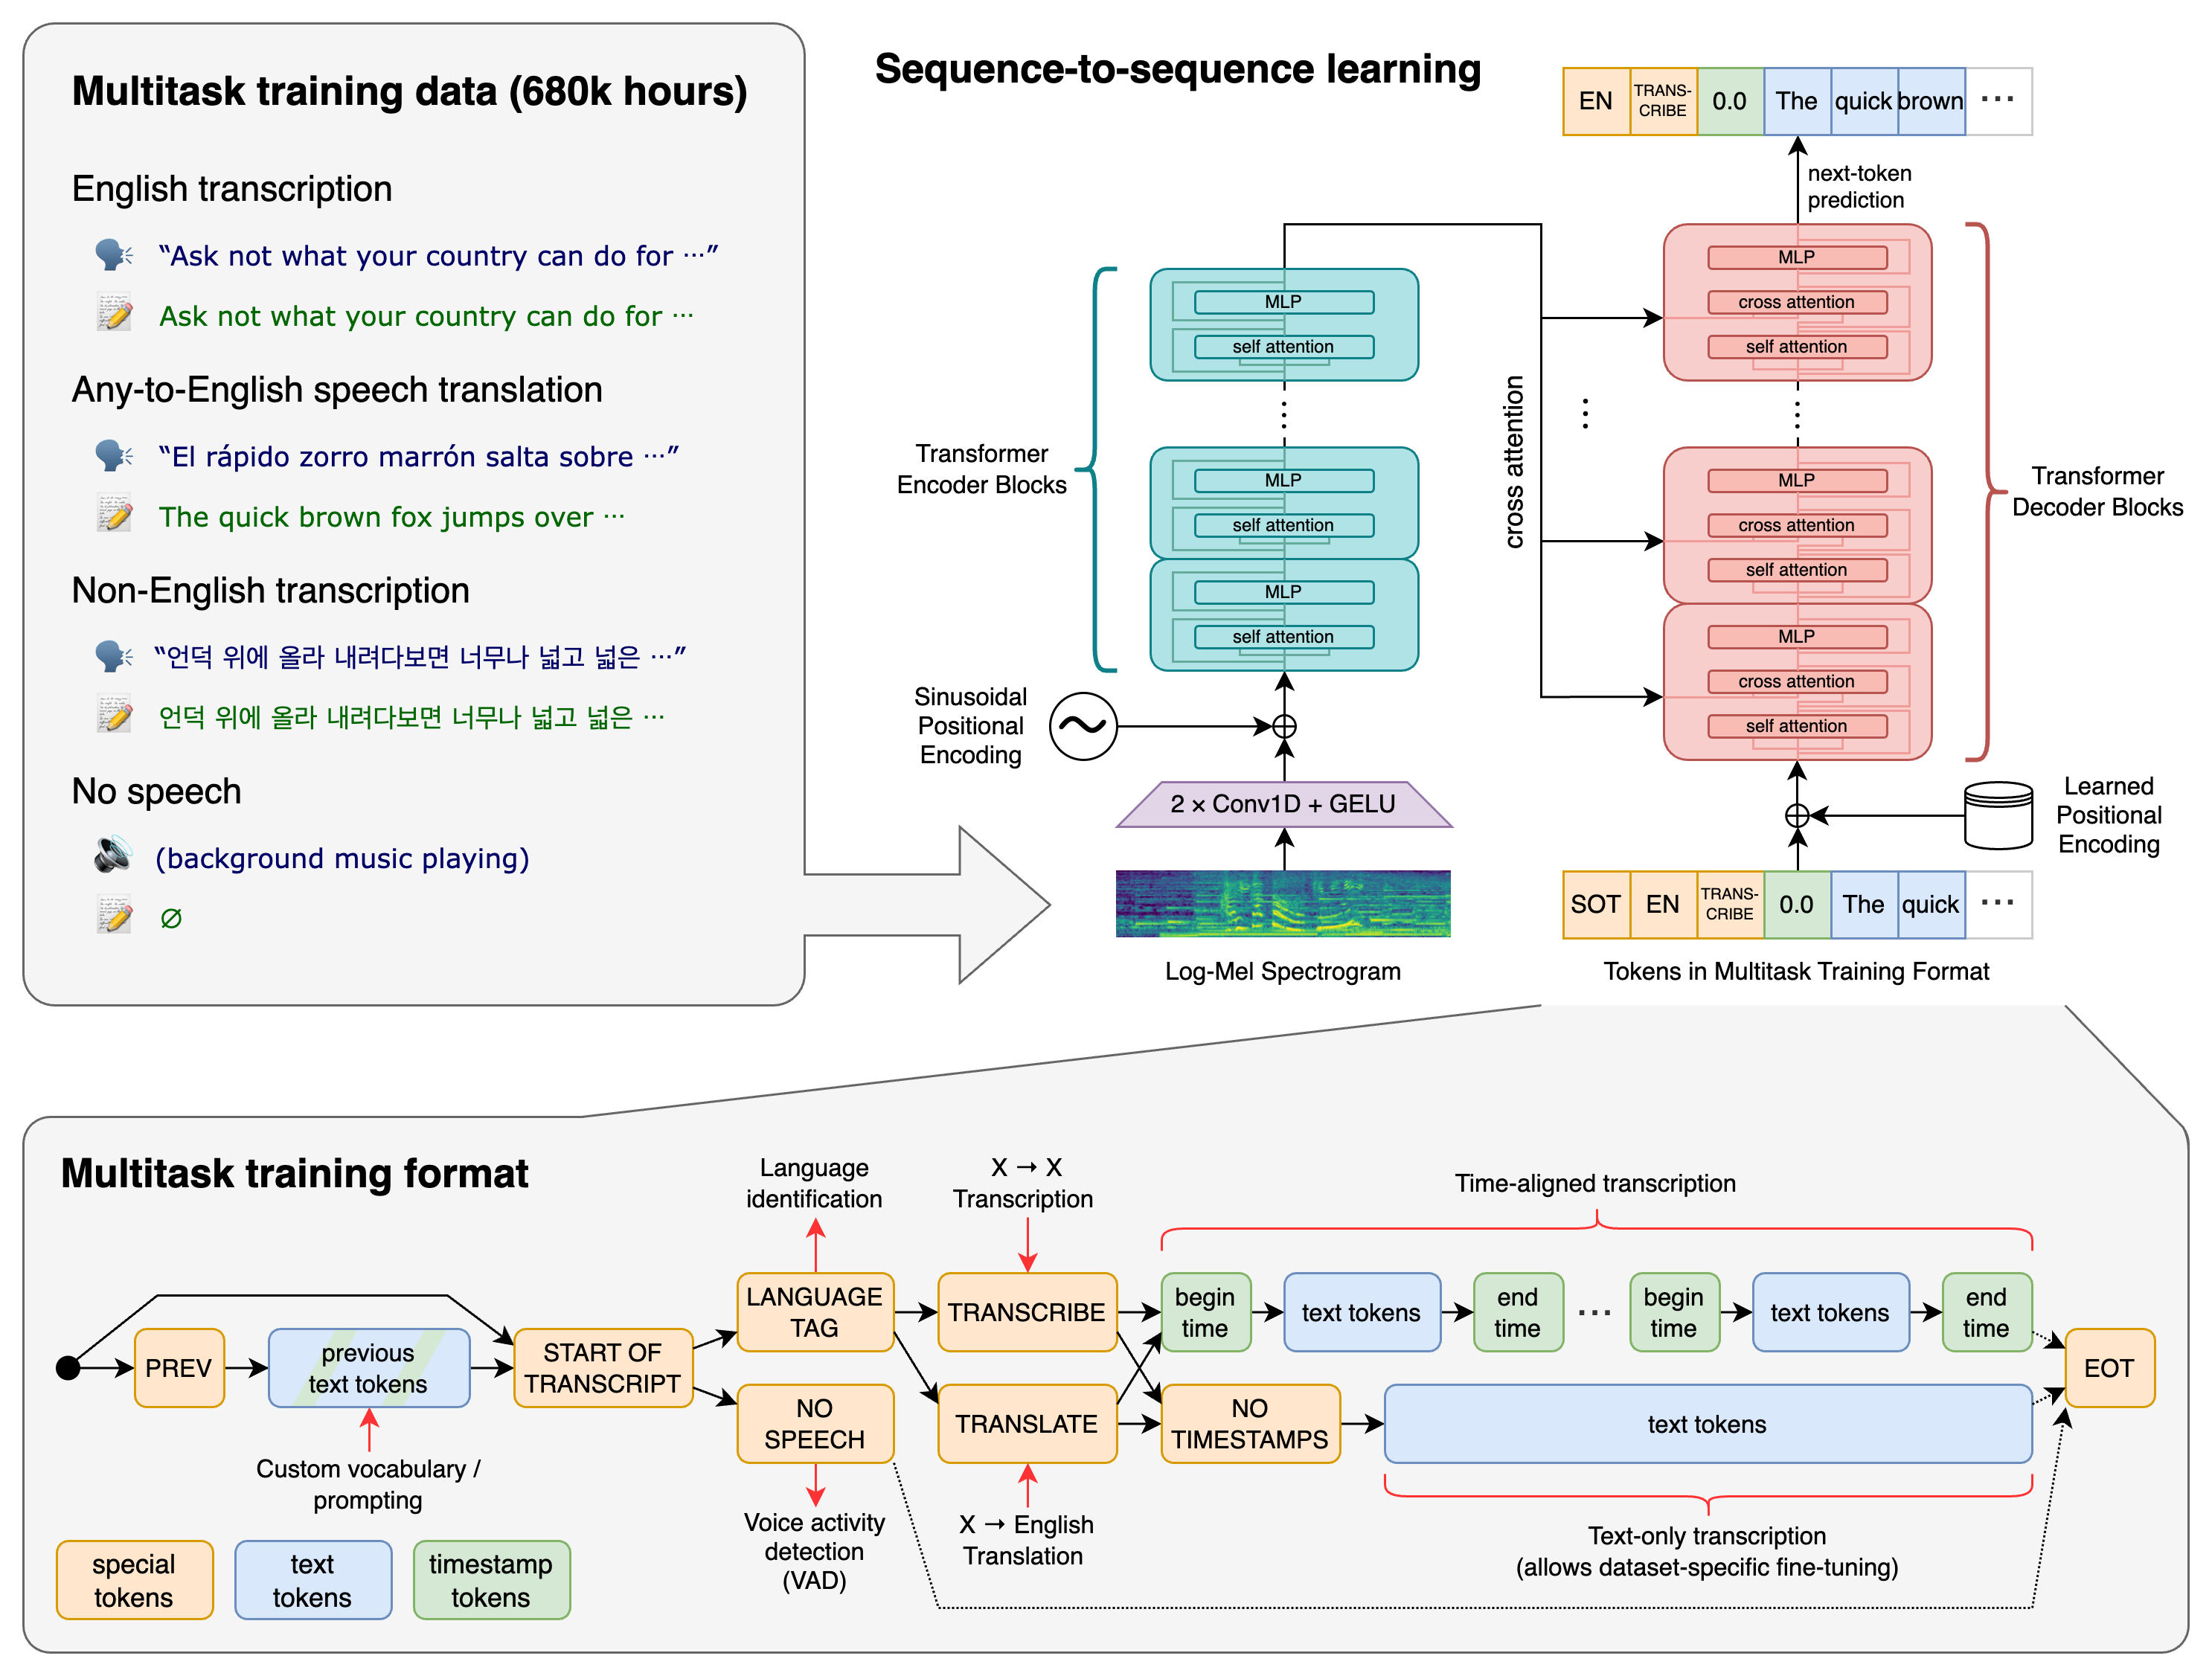

In [1]:
# Import necessary libraries
## 設定 OpenAI API Key 變數
from dotenv import load_dotenv
import os

# Load the environment variables from .env file
load_dotenv()

# Access the API key
openai_api_key = os.getenv('OPENAI_API_KEY')


In [2]:
import requests
import json
from pprint import pp

In [3]:
def get_completion(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=4000):
  payload = { "model": model, "temperature": temperature, "messages": messages, "max_tokens": max_tokens }
  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/chat/completions', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["choices"][0]["message"]["content"]
  else :
    return obj["error"]

## 來挑戰 1 小時的 podcast (超過25MB怎麼辦????)


step1 - Get [Rss feed](https://getrssfeed.com/)<br>
step2 - 選擇你想要的 podcast 節目 [大人學](https://podcasts.apple.com/tw/podcast/%E5%A4%A7%E4%BA%BA%E7%9A%84small-talk/id1452688611)<br>

In [4]:
import feedparser   

In [5]:
# 塞掐 Side Chat (來聽fox大大!!)
# https://omny.fm/shows/side-chat/playlists/side-chat
podcast_feed_url = "https://feeds.soundon.fm/podcasts/6731d283-54f0-49ec-a040-e5a641c3125f.xml"
podcast_feed = feedparser.parse(podcast_feed_url)
print ("The number of podcast entries is ", len(podcast_feed.entries))

The number of podcast entries is  488


In [6]:
podcast_feed.entries[0]

{'title': 'EP471 開箱大人學！Joe與Bryan的管理風格？大家都愛的員工福利？顧問的挑戰與該有的特質？外加最新招募情報！',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': 'https://feeds.soundon.fm/podcasts/6731d283-54f0-49ec-a040-e5a641c3125f.xml',
  'value': 'EP471 開箱大人學！Joe與Bryan的管理風格？大家都愛的員工福利？顧問的挑戰與該有的特質？外加最新招募情報！'},
 'summary': '你曾經嚮往在大人學工作嗎？其實「大人學」只是我們「識博管理顧問」的其中一部分而已！本質上，我們是一家管理顧問公司。你對「管理顧問」公司的印象是什麼呢？西裝筆挺？節奏明快？還是爆肝加班？本集節目中Bryan要來為你開箱大人學，分享他理想的管理風格、員工福利，以及這一行日常遇到的挑戰與期待的特質，如果你對於知識型商品，對於成人教育，對於企業服務、顧問服務等等這些方面有興趣的夥伴，歡迎參考下方的連結，一起加入我們的行列！ \n  \n【招募訊息】歡迎有興趣的夥伴加入！ \n104｜<a href="https://www.104.com.tw/company/d47j9dk">https://www.104.com.tw/company/d47j9dk</a> \n大人學官網｜<a href="https://sites.google.com/ftpm.com.tw/joinus/">https://sites.google.com/ftpm.com.tw/joinus/</a> \n  \n大人學課程 \n【101專案管理一日特訓班(7PDU)｜專案管理課程】 \n<a href="https://bit.ly/4c640r3">https://bit.ly/4c640r3</a> \n  \n相關集數 \n【EP215 影響我職涯最大的外掛技能 — 銷售能力】 \n<a href="https://youtu.be/Wc9NHYfY5uA?si=cJY4aPySNFoTvyLv">https://youtu.be/Wc9NHYfY5uA?si=cJY4aPySNFo

## 找出最長時數的節目

In [7]:

episode_length = 0
episode_title = ''
episode_url = ''

for item in podcast_feed.entries[0:10]:
    if 'itunes_duration' in item:
        duration = int(item.itunes_duration)
        if duration > episode_length:
            episode_length = duration
            episode_title = item.title
            for link in item.links:
                if link['type'] == 'audio/mpeg':
                    episode_url = link['href']
                    break

print(f"最長時數節目: {episode_title}, 時數: {episode_length} 秒, 連結: {episode_url}")


最長時數節目: EP467 當HR都在逛LinkedIn，你還在用人力銀行求職嗎？打通求職新管道：你不知道的LinkedIn經營小密技｜企業外語訓練師 陳湘陽 Sonny 專訪, 時數: 3215 秒, 連結: https://chtbl.com/track/75B659/track.fstry.me/p/d85b4grj/rss.soundon.fm/rssf/6731d283-54f0-49ec-a040-e5a641c3125f/feedurl/66fdd8b0-deef-460f-8282-5aa5d215e609/rssFileVip.mp3?timestamp=1716756770830


## 下載檔案

In [8]:
# import requests

# def download_audio(url, save_path):
#     response = requests.get(url)
#     with open(save_path, 'wb') as file:
#         file.write(response.content)
#     print(f"Audio downloaded successfully and saved to {save_path}")


# episode_url = episode_url  # 替換為實際的音訊URL
# save_path = "./data/podcast_episode_long.mp3"
# download_audio(episode_url, save_path)


# # 你也可以使用 linux 指令下載
# # !wget -O 'podcast_episode_long.mp3' {episode_url}


## 計算音訊檔案大小

In [9]:
# def get_file_size(file_path):
#     file_size = os.path.getsize(file_path)
#     file_size_mb = file_size / (1024 * 1024)
#     return file_size_mb


# file_size_mb = get_file_size(save_path)
# print(f"Downloaded file size: {file_size_mb:.2f} MB")


In [10]:
data = { "model": "whisper-1", "prompt": "請用台灣繁體中文" } #  flac, mp3, mp4, mpeg, mpga, m4a, ogg, wav, or webm
f = open('./data/podcast_episode_long.mp3', 'rb')
files = [("file", ("podcast_episode_long.mp3", f, "application/octet-stream"))]

headers = { "Authorization": f'Bearer {openai_api_key}' } # 不需要加 "Content-Type": "multipart/form-data" 因為我猜 request libray 幫你加了
response = requests.post('https://api.openai.com/v1/audio/transcriptions', headers = headers, data = data, files = files )
pp(response.text)

('{\n'
 '  "error": {\n'
 '    "message": "Maximum content size limit (26214400) exceeded (26216850 '
 'bytes read)",\n'
 '    "type": "server_error",\n'
 '    "param": null,\n'
 '    "code": null\n'
 '  }\n'
 '}')


OpenAI API 至多 25M，狠狠超過了.....
那就來自己 hosting model 吧!! 官方有釋出模型可以自行安裝。

* 官方版 https://github.com/openai/whisper
* CPU 效能優化版 https://github.com/ggerganov/whisper.cpp

在這個 colab 跑的話，記得選 GPU（編輯 -> 筆記本設定 -> 硬體加速器: 選個 GPU）<br>
***不用 colab 電腦記得裝 CUDA 讓 whisper 可以自動偵測到 GPU

In [11]:
# !pip install openai-whisper -q
# !pip install setuptools-rust

安装
Whisper主要基于pytorch實現，所以需要在安装有pytorch的环境中使用。

环境准备
在安装之前需要准备ffmpeg、Rust
Linux：
sudo apt update && sudo apt install ffmpeg

window：
可以直接https://www.ffmpeg.org/官網下載或者[github](https://github.com/BtbN/FFmpeg-Builds/releases)下载（ffmpeg-N-110946-g859c34706d-win64-gpl.zip）。下载之后解壓縮。

                    
原文：<br>
https://blog.csdn.net/weixin_40964597/article/details/131055341<br>
https://phoenixnap.com/kb/ffmpeg-windows


if occure issue

[找不到系統檔案]
https://blog.csdn.net/qq_24118527/article/details/90579328




In [12]:
import whisper
print ("Download and Load the Whisper model")
model = whisper.load_model("medium") # 模型有分不同大小 medium 1.42G, large: 2.87G
print (model.device) # cpu 會跑很久..... 因此一開始要選 gpu

Download and Load the Whisper model
cpu


In [22]:
result = model.transcribe("./data/podcast_episode_long.mp3", fp16=False) 

In [23]:
long_podcast_transcript = result["text"]
pp(long_podcast_transcript)

('本期節目由大仁學贊助提供大家都希望擁有一份薪資更高福利更好更有發展性的工作但是為了這份理想你為自己做過什麼樣的努力呢?多數人往往要到實在受不了工作的時候才會開始搜尋職缺修改履歷然後一邊擔心老闆同事發現一邊偷偷的打開人力銀行檔案期待剛好在這段時間有理想的工作出現不過現在科技這麼發達難道沒有更好的方法讓我們的履歷能夠一年365天持續曝光不用看老闆臉色還能讓全世界的企業甚至獵人頭公司都能發現我們呢?答案是有的那就是Linkin這個社群平台這就是為什麼它已經成為全球專業工作者求職的首選收聽節目的你絕對也聽過它2024年的今天你一定要開始經營Linkin讓你的職業夢想更進一步大人學與知名的留學顧問與口譯專家Somnie老師合作開設了全新的Linkin經營全攻略線上課程幫助你用最基礎的英文能力搭配AI工具在Linkin上建立你專業的個人profile讓全球一流的企業隨時能夠追蹤你創造契機同時也會教你Smalltalk的基本技巧幫助你能在平台上與全球的專業工作者自在交流累積人脈現在加入Linkin經營全攻略課程可以享受募資期間的優惠價格擦亮個人品牌拓展國際人脈越早開始越早啟動你的福利效應歡迎透過節目的說明欄觀看這堂課更多的介紹歡迎收聽大人的Smalltalk這是大人學的Podcast節目我是Brian最近行政院的主計數公佈了台灣人的人均薪資我不知道大家有沒有follow這個新聞在我的視訊網站上很多人已發討論它這個最新公佈的台灣人薪資是有到58K5萬8包含加班費跟獎金然後網友就紛紛表示哎呀真抱歉我拉低了大家的平均值其實就算是真的有58K感覺好像也沒有很高對不對因為你看在台灣現在房價節節高升尤其是北部隨便一個房子都兩千萬三千萬起跳我們都常好奇滿街都是雙B的車我們這些上班族就常想到底是誰在買這些那麼貴的東西事實上台灣的薪資低是我們長久以來遇到的問題可是很矛盾的是我們周圍又不時看到有些人的薪資很高很高像一些竹科的工程師他其實做了什麼兩三百萬好像都很隨便的可以拿到所以我自己有很多學生就在問老師到底我一個月賺個三萬四萬我要怎麼樣拉高我的薪水還有為什麼有人年薪可以到兩三百萬想想就很不可思議的數據所以今天我們就請到了我們的好朋友Sony老師來跟大家聊聊到底我們一般的上班族有沒有什麼方法有沒有什麼路徑讓我們的薪資可以提升到另外一個水準我們有沒有什麼一些比較務實的方法可以去做哈囉SonyHi '

In [24]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

long_num_tokens = len(encoding.encode(long_podcast_transcript))
print(long_num_tokens)

21937


 這種長文本，一個 prompt 塞不下 16k 的 gpt-3.5，要怎麼做摘要?

1. 換 context window 更大的模型，例如 gpt-4-turbo 可以 128k、gemini-pro 1.5 可以 1000k
2. 將內容拆段處理

## Map-Reduce 方法

In [25]:
!pip install langchain -q

In [26]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

langchain 的 RecursiveCharacterTextSplitter 方式是個常見的拆段落方式

https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter

預設會依序用這四個字元來拆 ["\n\n", "\n", " ", ""]

In [27]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)

texts = text_splitter.split_text(long_podcast_transcript)
len(texts)

11

## 開多線程

https://blog.gtwang.org/programming/python-threading-multithreaded-programming-tutorial/

In [28]:
import threading

def process_summary(index, content, results):
  # Tl;dr 是 too long; didn't read 的意思，國外鄉民常用的懶人包縮寫
  messages = [
    {
      "role": "user",
      "content": content + ' Tl;dr (#zh-tw):'
    }
  ]
  print("Sent request: " + content)
  abstract_summary = get_completion(messages, model="gpt-3.5-turbo-16k")
  results[index] = abstract_summary

results = [None] * len(texts)
threads = []
# 透過 threads 平行發送所有 requests 進行摘要
for i, item in enumerate(texts):
    t = threading.Thread(target=process_summary, args=(i, item, results))
    t.start()
    threads.append(t)

for t in threads:
    t.join()  # 等待每個 thread 都完成


print(results)

Sent request: 本期節目由大仁學贊助提供大家都希望擁有一份薪資更高福利更好更有發展性的工作但是為了這份理想你為自己做過什麼樣的努力呢?多數人往往要到實在受不了工作的時候才會開始搜尋職缺修改履歷然後一邊擔心老闆同事發現一邊偷偷的打開人力銀行檔案期待剛好在這段時間有理想的工作出現不過現在科技這麼發達難道沒有更好的方法讓我們的履歷能夠一年365天持續曝光不用看老闆臉色還能讓全世界的企業甚至獵人頭公司都能發現我們呢?答案是有的那就是Linkin這個社群平台這就是為什麼它已經成為全球專業工作者求職的首選收聽節目的你絕對也聽過它2024年的今天你一定要開始經營Linkin讓你的職業夢想更進一步大人學與知名的留學顧問與口譯專家Somnie老師合作開設了全新的Linkin經營全攻略線上課程幫助你用最基礎的英文能力搭配AI工具在Linkin上建立你專業的個人profile讓全球一流的企業隨時能夠追蹤你創造契機同時也會教你Smalltalk的基本技巧幫助你能在平台上與全球的專業工作者自在交流累積人脈現在加入Linkin經營全攻略課程可以享受募資期間的優惠價格擦亮個人品牌拓展國際人脈越早開始越早啟動你的福利效應歡迎透過節目的說明欄觀看這堂課更多的介紹歡迎收聽大人的Smalltalk這是大人學的Podcast節目我是Brian最近行政院的主計數公佈了台灣人的人均薪資我不知道大家有沒有follow這個新聞在我的視訊網站上很多人已發討論它這個最新公佈的台灣人薪資是有到58K5萬8包含加班費跟獎金然後網友就紛紛表示哎呀真抱歉我拉低了大家的平均值其實就算是真的有58K感覺好像也沒有很高對不對因為你看在台灣現在房價節節高升尤其是北部隨便一個房子都兩千萬三千萬起跳我們都常好奇滿街都是雙B的車我們這些上班族就常想到底是誰在買這些那麼貴的東西事實上台灣的薪資低是我們長久以來遇到的問題可是很矛盾的是我們周圍又不時看到有些人的薪資很高很高像一些竹科的工程師他其實做了什麼兩三百萬好像都很隨便的可以拿到所以我自己有很多學生就在問老師到底我一個月賺個三萬四萬我要怎麼樣拉高我的薪水還有為什麼有人年薪可以到兩三百萬想想就很不可思議的數據所以今天我們就請到了我們的好朋友Sony老師來跟大家聊聊到底我們一般的上班族有沒有什麼方法有沒有什麼路徑讓我們的薪資可以提升到另外一個水準我們有沒有什麼一些比較務實的方法可以

## 將所有子摘要合併成一個摘要

In [29]:
# 把所有子摘要集合起來
content = "\n".join("\n" + item for item in results)
messages = [
    {
      "role": "user",
      "content": content + ' Tl;dr (#zh-tw):'
    }
]

print(content)


本期節目由大仁學贊助提供，我們都希望擁有一份薪資更高、福利更好、更有發展性的工作。但是為了這份理想，你為自己做過什麼樣的努力呢？很多人往往要到實在受不了工作的時候才會開始搜尋職缺，修改履歷，然後一邊擔心老闆同事發現，一邊偷偷的打開人力銀行檔案，期待剛好在這段時間有理想的工作出現。不過現在科技這麼發達，難道沒有更好的方法讓我們的履歷能夠一年365天持續曝光，不用看老闆臉色，還能讓全世界的企業甚至獵人頭公司都能發現我們呢？答案是有的，那就是LinkedIn這個社群平台。這就是為什麼它已經成為全球專業工作者求職的首選。收聽節目的你絕對也聽過它。2024年的今天，你一定要開始經營LinkedIn，讓你的職業夢想更進一步。大人學與知名的留學顧問與口譯專家Somnie老師合作開設了全新的LinkedIn經營全攻略線上課程，幫助你用最基礎的英文能力搭配AI工具，在LinkedIn上建立你專業的個人profile，讓全球一流的企業隨時能夠追蹤你，創造契機。同時也會教你Smalltalk的基本技巧，幫助你能在平台上與全球的專業工作者自在交流，累積人脈。現在加入LinkedIn經營全攻略課程，可以享受募資期間的優惠價格，擦亮個人品牌，拓展國際人脈。越早開始，越早啟動你的福利效應。歡迎透過節目的說明欄觀看這堂課，更多的介紹。歡迎收聽大人的Smalltalk，這是大人學的Podcast節目，我是Brian。

最近行政院的主計數公佈了台灣人的人均薪資，我不知道大家有沒有follow這個新聞。在我的視訊網站上，很多人已發討論它。這個最新公佈的台灣人薪資是有到58K（5萬8），包含加班費跟獎金。然後網友就紛紛表示哎呀，真抱歉我拉低了大家的平均值。其實就算是真的有58K，感覺好像也沒有很高對不對？因為你看在台灣現在房價節節高升，尤其是北部，隨便一個房子都兩千萬、三千萬起跳。我們都常好奇，滿街都是雙B的車，我們這些上班族就常想，到底是誰在買這些那麼貴的東西。

事實上，台灣的薪資低是我們長久以來遇到的問題。可是很矛盾的是，我們周圍又不時看到有些人的薪資很高，很高，像一些竹科的工程師，他其實做了什麼，兩三百萬好像都很隨便的可以拿到。所以我自己有很多學生就在問老師，到底我一個月賺個三萬、四萬，我要怎麼樣拉高我的薪水？還有為什麼有人年薪可以到兩三百萬？想想就很不可思議的數據。

所以今天我們就請到了我

## 最後將上述加總的小摘要，再摘要一次，得到整體摘要

In [30]:
final_summary = get_completion(messages, model="gpt-4-turbo-preview")

print(final_summary)

本期節目討論了如何提升薪資和利用LinkedIn來尋找更好的工作機會。LinkedIn作為一個專業社群平台，與傳統人力銀行的最大不同在於它能讓個人的履歷持續曝光，並且提供了建立個人品牌、拓展人脈和學習新技能的工具和資源。此外，節目中提到了LinkedIn上的背書和推薦功能，以及如何利用LinkedIn來建立人脈和尋找工作機會。對於剛畢業沒有經驗的學生，也可以通過展示實習經驗、證書或奖狀、參加課程和認證來提升自己的競爭力。此外，節目還提到了如何利用AI工具來改善英文表達，以及如何在LinkedIn上有效地與人交流和建立關係。最後，強調了在LinkedIn上保持活躍和更新的重要性，以及如何透過這個平台來尋找和把握機會。


> 後記
>
> 文本解析出來沒有標點符號，沒有像電影劇本有不同角色標籤，因為口語會有很多語助詞，模型很容易誤判加上口音問題，這些都必須要解決